In [2]:
# importing necessary libraries

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torch
import torch.nn as nn
import requests
from torchvision import transforms, models

In [3]:
# for extracting content and style from the images
# we are gonna use image representation from vgg model

vgg = models.vgg19(pretrained=True).features
vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# freezing parametres from training

for param in vgg.parameters():
    param.requires_grad_(False)
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [5]:
# check for gpu
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(path, max_size=400, shape=None):
    if "http" in path:
        response = requests.get(path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(path).convert("RGB")

    # making the image size same
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # pre-processing the image
    transform = transforms.Compose([
                                    transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))
    ])

    image = transform(image)
    image = image.unsqueeze(0)

    return image

In [7]:
content = load_image('drive/My Drive/style_transfer/landscape.jpg').to(device)
style = load_image('drive/My Drive/style_transfer/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', shape = content.shape[-2:]).to(device)

In [8]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

(3, 400, 599)
(400, 599, 3)
(3, 400, 599)
(400, 599, 3)


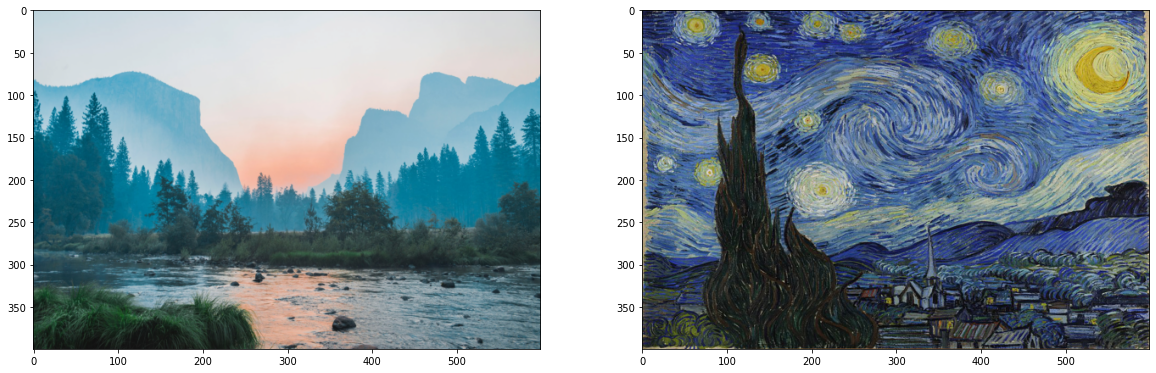

In [9]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# content and style image side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [10]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    #print(features)
    return features

In [11]:
def gram_matrix(tensor):
    _, d, w, h = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [12]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [13]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [14]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e8

Total loss:  35264940.0
(3, 400, 599)
(400, 599, 3)


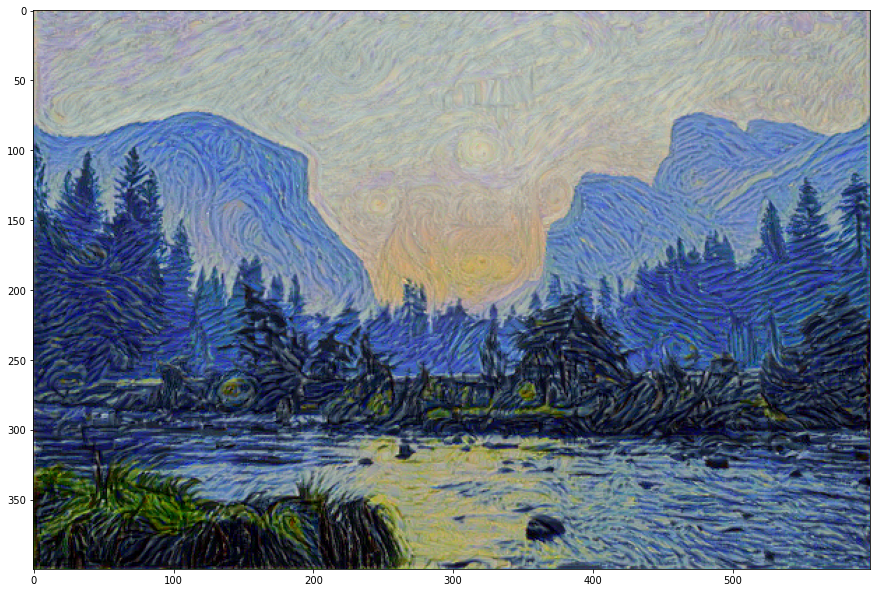

Total loss:  13691702.0
(3, 400, 599)
(400, 599, 3)


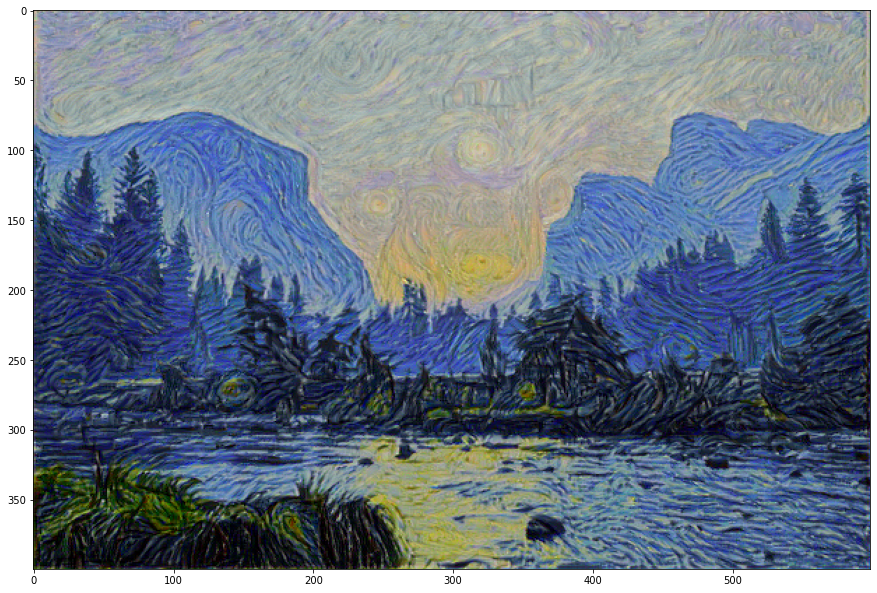

Total loss:  8771840.0
(3, 400, 599)
(400, 599, 3)


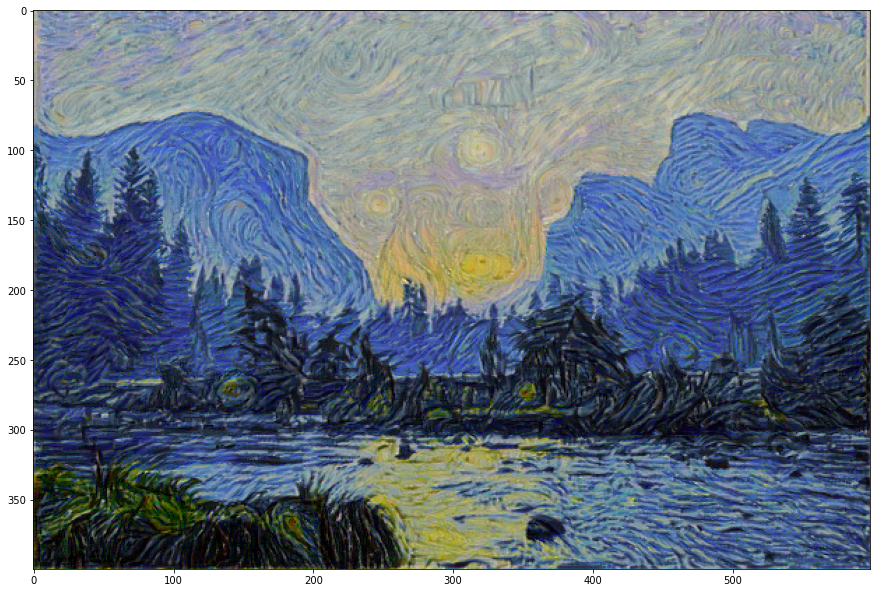

Total loss:  6680149.0
(3, 400, 599)
(400, 599, 3)


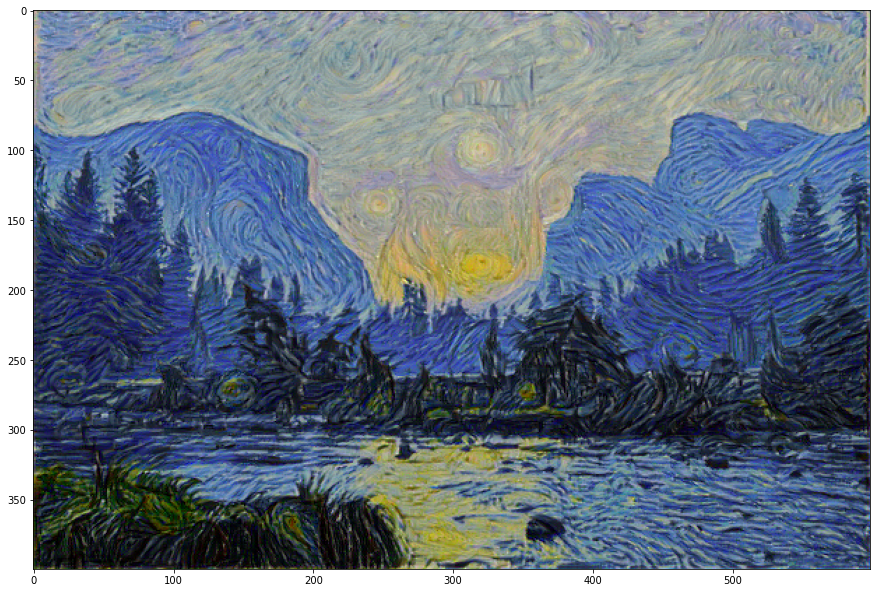

In [16]:
show_every = 500

optimizer = optim.Adam([target], lr = 0.003)
steps = 2000

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)

    style_loss = 0
    for layer in  style_weights:
        target_feature = target_features[layer]

        target_gram = gram_matrix(target_feature)

        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.figure(figsize = (15,15))
        plt.imshow(im_convert(target))
        plt.show()